In [56]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Introduce Bureau Labor Statistics reports and background on subject

In [52]:
bls_data = pd.read_csv('data/BLS_data.csv')
bls_data

,Unnamed: 0,year,month,value,report
0,0,2021,April,267.054,CPI
1,1,2021,March,264.877,CPI
2,2,2021,February,263.014,CPI
3,3,2021,January,261.582,CPI
4,4,2020,December,260.474,CPI
...,...,...,...,...,...
1153,1153,2002,May,433.000,Manufacturing Separations
1154,1154,2002,April,491.000,Manufacturing Separations
1155,1155,2002,March,397.000,Manufacturing Separations
1156,1156,2002,February,415.000,Manufacturing Separations


In [54]:
bls_data=bls_data.drop(columns = ['Unnamed: 0'])

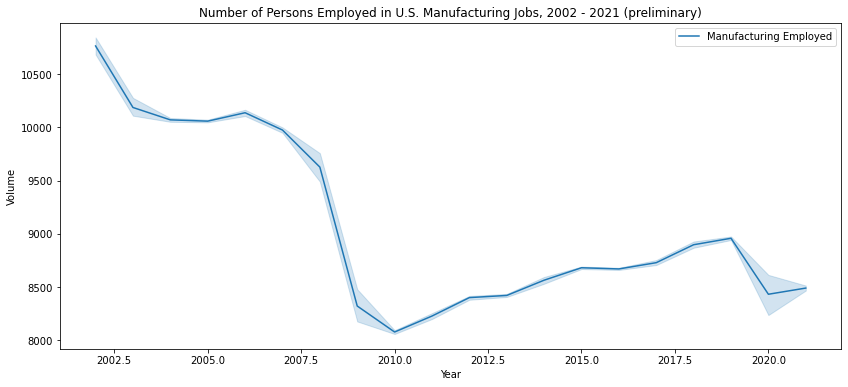

In [57]:
manu_employed = bls_data[bls_data['report']=='Manufacturing Employed']
#manu_openings = BLS_final[BLS_final['report']=='Manufacturing Job Openings']
#manu_hires = BLS_final[BLS_final['report']=='Manufacturing Hires']
#manu_seps = BLS_final[BLS_final['report']=='Manufacturing Separations']

fig = plt.subplots(figsize = (14, 6))
sns.lineplot(manu_employed['year'],manu_employed['value'],label="Manufacturing Employed")
#sns.lineplot(manu_openings['year'],manu_openings['value'],label="Manufacturing Job Openings")
#sns.lineplot(manu_hires['year'],manu_hires['value'],label="Manufacturing New Hires")
#sns.lineplot(manu_seps['year'],manu_seps['value'], label = "Manufacturing Separations")

plt.xlabel('Year')
plt.ylabel('Volume')
plt.title('Number of Persons Employed in U.S. Manufacturing Jobs, 2002 - 2021 (preliminary)')
plt.legend();

#html_manu_employed = mpld3.fig_to_html(fig)
#mpld3.save_html(fig,'../Capstone_US_Blue_Collar_workers/data/BLS_trends.html')

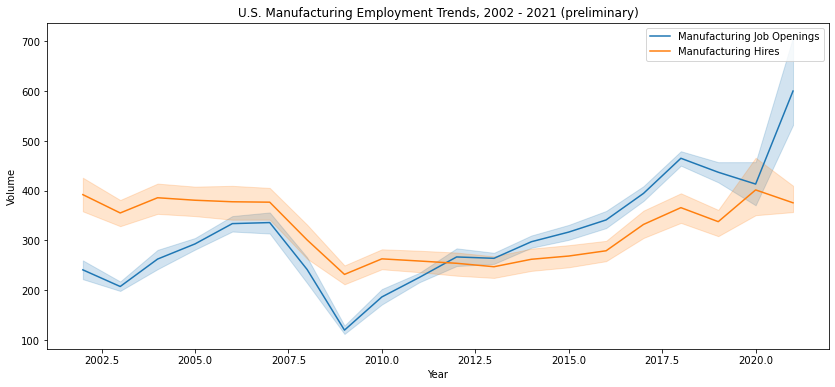

In [58]:
manu_openings = bls_data[bls_data['report']=='Manufacturing Job Openings']
manu_hires = bls_data[bls_data['report']=='Manufacturing Hires']

fig = plt.subplots(figsize = (14, 6))
sns.lineplot(manu_openings['year'],manu_openings['value'],label="Manufacturing Job Openings")
sns.lineplot(manu_hires['year'], manu_hires['value'], label = "Manufacturing Hires")

plt.xlabel('Year')
plt.ylabel('Volume')
plt.title('U.S. Manufacturing Employment Trends, 2002 - 2021 (preliminary)')
plt.legend();

## Bring in previously-pulled reports for Material Handlers, Assemblers, Warehouse job listings for TN and TX

In [48]:
bluecollar_csv = bluecollar.to_csv('data/full_bc_jobs.csv')

In [49]:
#read in full bluecollar concatenated jobs dataframe
full_bluecollar = pd.read_csv('data/full_bc_jobs.csv')
full_bluecollar.shape

(15313, 11)

Now, identify keywords that could imply criticality of finding talent, search the job snippet and job description fields, and count the number of times the keywords appear

Run the keywords against "full job description".  Note that the keywords were also run against the "job snippet" column
but the total counts were less than the full job description counts, so the snippet column was removed.

In [50]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\daily\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daily\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


And then run the words against the "full_description"

In [51]:
#'no' is in the English stop words, so in order to include 'no experience necessary' remove "no" from stopwords'

def preprocess_text(full_description):
    full_description = full_description.lower() 
    translator = str.maketrans('', '', string.punctuation)
    full_description = full_description.translate(translator)
    stop_words = set(stopwords.words('english'))
    not_stopwords = {'no'}
    final_stopwords = set([word for word in stop_words if word not in not_stopwords])
    filtered_words = [w for w in full_description.split() if w not in final_stopwords] 
    return ' '.join(filtered_words) 


In [59]:
KEYWORDS = ['bonus', 'bonuses','pay increase', 'pay increases', 'immediately', 'incentive', 'incentives','no experience necessary']

def count_keywords(full_description):
    counts = {}
    prep = preprocess_text(full_description)
    for kw in KEYWORDS:
        counts[kw] = prep.count(kw)
    return counts



In [60]:
bluecollar['occur_full_desc'] = bluecollar['full_description'].apply(count_keywords)

In [61]:
bluecollar.shape

(15313, 11)

In [62]:
full_desc_incent = bluecollar.occur_full_desc.tolist()

In [63]:
pd.DataFrame(full_desc_incent)

,bonus,bonuses,pay increase,pay increases,immediately,incentive,incentives,no experience necessary
0,0,0,0,0,2,0,0,0
1,0,0,0,0,2,0,0,0
2,1,1,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
15308,1,0,0,0,0,0,0,0
15309,1,0,0,0,0,0,0,0
15310,1,0,0,0,0,0,0,0
15311,1,0,0,0,0,0,0,0


In [64]:
bluecollar = bluecollar.reset_index()

In [66]:
bluecollar3 = pd.concat([bluecollar, pd.DataFrame(full_desc_incent).reset_index()], axis=1)

In [67]:
bluecollar3.shape

(15313, 21)

In [68]:
bluecollar3.head(2)

,index,category,state,title,employer,city,snippet,full_description,education,min_pay,max_pay,occur_full_desc,index,bonus,bonuses,pay increase,pay increases,immediately,incentive,incentives,no experience necessary
0,0,Assembler,TN,Assembler,"Accurate Personnel, LLC",Knoxville,... ASSEMBLER - EARN $14/HOUR We are hiring i...,"Job Description Hello First Name, We are excit...",No Minimum Education Requirement,None,None,"{'bonus': 0, 'bonuses': 0, 'pay increase': 0, ...",0,0,0,0,0,2,0,0,0
1,1,Assembler,TN,Assembler,"Accurate Personnel, LLC",Knoxville,... ASSEMBLER - EARN $14/HOUR We are hiring i...,Job Description HIRING IMMEDIATELY: ASSEMBLER ...,No Minimum Education Requirement,None,None,"{'bonus': 0, 'bonuses': 0, 'pay increase': 0, ...",1,0,0,0,0,2,0,0,0


In [69]:
bluecollar3.describe()

,index,index,bonus,bonuses,pay increase,pay increases,immediately,incentive,incentives,no experience necessary
count,15313.00000,15313.000000,15313.000000,15313.000000,15313.000000,15313.000000,15313.000000,15313.000000,15313.000000,15313.000000
mean,9339.21374,7656.000000,0.172664,0.048978,0.009534,0.004245,0.065173,0.043231,0.020179,0.006008
std,5230.59899,4420.626671,0.608815,0.256736,0.106786,0.071703,0.277245,0.218254,0.140617,0.086831
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4964.00000,3828.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9277.00000,7656.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13989.00000,11484.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18236.00000,15312.000000,12.000000,12.000000,3.000000,3.000000,5.000000,4.000000,1.000000,2.000000


In [70]:
bluecollar3['bonus_ttl'] = bluecollar3['bonus'] + bluecollar3['bonuses']
#bluecollar3

In [71]:
bluecollar3['incentive_ttl'] = bluecollar3['incentive'] + bluecollar3['incentives']
#bluecollar3

In [72]:
bluecollar3['increase_ttl'] = bluecollar3['pay increase'] + bluecollar3['pay increases']
#bluecollar3

In [73]:
bluecollar3 = bluecollar3.drop(columns = ['occur_full_desc', 'bonus', 'bonuses', 'incentive', 'incentives', 'pay increase', 'pay increases'])

In [74]:
bluecollar3 = bluecollar3.rename(columns = {'bonus_ttl': 'bonus', 'incentive_ttl':'incentive', 'increase_ttl':'pay increase'})

In [75]:
bluecollar3['total keywords'] = bluecollar3['incentive'] + bluecollar3['pay increase'] + bluecollar3['no experience necessary'] + bluecollar3['immediately'] + bluecollar3['bonus']
bluecollar3.head(2)

,index,category,state,title,employer,city,snippet,full_description,education,min_pay,max_pay,index,immediately,no experience necessary,bonus,incentive,pay increase,total keywords
0,0,Assembler,TN,Assembler,"Accurate Personnel, LLC",Knoxville,... ASSEMBLER - EARN $14/HOUR We are hiring i...,"Job Description Hello First Name, We are excit...",No Minimum Education Requirement,None,None,0,2,0,0,0,0,2
1,1,Assembler,TN,Assembler,"Accurate Personnel, LLC",Knoxville,... ASSEMBLER - EARN $14/HOUR We are hiring i...,Job Description HIRING IMMEDIATELY: ASSEMBLER ...,No Minimum Education Requirement,None,None,1,2,0,0,0,0,2


In [78]:
bluecollar3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15313 entries, 0 to 15312
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    15313 non-null  int64 
 1   category                 15313 non-null  object
 2   state                    15313 non-null  object
 3   title                    15313 non-null  object
 4   employer                 15277 non-null  object
 5   city                     15313 non-null  object
 6   snippet                  15313 non-null  object
 7   full_description         15313 non-null  object
 8   education                15313 non-null  object
 9   min_pay                  3639 non-null   object
 10  max_pay                  3614 non-null   object
 11  index                    15313 non-null  int64 
 12  immediately              15313 non-null  int64 
 13  no experience necessary  15313 non-null  int64 
 14  bonus                    15313 non-nul

In [79]:
bluecollar3['total keywords'].sum()

5666

In [80]:
#create column and assigns a "1" if there is a number that is >= 1 in the total keywords column
bluecollar3['occur'] = bluecollar3['total keywords'].apply(lambda x: "1" if x >= 1 else "0")

In [81]:
bluecollar3['occur'].value_counts()

0    12418
1     2895
Name: occur, dtype: int64

Left off here.. 

In [ ]:
import plotly.graph_objects as go

field =['Bluecollar', 'Marketing']

fig = go.Figure(data=[
    go.Bar(name='occurence', x=field, y=[19,12], 
          ),
    go.Bar(name='no occurence', x=field, y=[81,88])
])
# Change the bar mode
fig.update_layout(barmode='stack', title = "Percent of Job Descriptions with Keywords", 
       xaxis_title = 'Job Discipline', yaxis_title =  
       'Percentage', width = 400, height = 400)
fig.show()

fig.write_html('../Capstone_US_Blue_Collar_workers/data/percent_of_postings_by_job.html')

In [ ]:
bluecollar3['employer'] = bluecollar3['employer'].replace("Not Available", 'Recruiter, Other 3rd Party')

In [ ]:
bluecollar3['employer'].unique()

In [ ]:
keyword_compare = bluecollar3.drop(columns = ['title', 'employer', 'full_description', 'education', 'min_pay', 'max_pay'])
keyword_compare.head(3)

In [ ]:
keyword_compare.info()

In [ ]:
keyword_compare[['incentive', 'pay increase', 'immediately', 'bonus', 'no experience necessary', 'total keywords']].sum().plot(kind='bar',
                                                                                                                            title='Keywords Found in Job Descriptions')
plt.show()

In [ ]:
keyword_compare = bluecollar3.drop(columns = ['title', 'employer', 'full_description', 'min_pay', 'max_pay'])
keyword_compare.head(3)

In [ ]:
keyword_compare['total keywords'].sum()

In [ ]:
bc_percent = bluecollar3['total keywords'].sum() / bluecollar3['snippet'].count()*100
bc_percent


In [ ]:
bluecollar3.groupby('state')['total keywords'].sum().plot(kind = 'bar', title = 'Keyword Incidences by State')
plt.show()

In [ ]:
employer_compare = bluecollar3.groupby('employer')['total keywords'].sum().sort_values(ascending=False).head(10)
employer_compare

In [ ]:
employer_compare.plot(kind='bar', title = 'Keyword Incidences by Employer (top 10)')
plt.show()

In [ ]:
bluecollar3.groupby('employer')['employer'].count().sort_values(ascending=False).head(10)#.plot(kind='bar', title='Job Postings by Employer')

In [ ]:
#bluecollar3[bluecollar3.employer.isin(['Amazon Fulfillment', 'AMAZON.COM', 'Amazon.com, Inc.'])]
#this produced 145 rows

Tackle the wages for blue collar workers and compare against MIT living wage 

In [ ]:
wages = bluecollar3[['category', 'state', 'city', 'title', 'min_pay', 'max_pay']]

In [ ]:
wages.info()

In [ ]:
wages['min_pay'] = wages['min_pay'].str.replace(r"[\''\,$]", '').dropna()
#.astype(int)   #.dropna() #test['Address 1'] = test['Address 1'].str.replace(r"[\"\',]", '')

In [ ]:
wages = wages.dropna()

In [ ]:
wages.shape

In [ ]:
#wages.min_pay.unique()

In [ ]:
#wages.max_pay.unique()

In [ ]:
wages['max_pay'] = wages['max_pay'].str.replace(r"[\''\,$]", '')

In [ ]:
wages['max_pay'].unique()

In [ ]:
wages['min_pay'] = pd.to_numeric(wages['min_pay'])

In [ ]:
wages = wages.sort_values(by = 'min_pay')

In [ ]:
wages

In [ ]:
wages[wages['min_pay'] >= 60000]

In [ ]:
wages = wages[wages['min_pay']<=60000]

In [ ]:
wages.shape

In [ ]:
wages.tail(200)

In [ ]:
wages_output = wages.to_csv('data/wages_output.csv')

In [ ]:
wages_standardized = pd.read_csv('data/wages_output_standardized.csv', index_col=0)
wages_standardized.head(3)

In [ ]:
wages_standardized = wages_standardized.dropna()

In [ ]:
wages_standardized['ave_pay'] = ((wages_standardized['min_pay_stdzd'] + wages_standardized['max_pay_stdzd'])/2)
wages_standardized.head()

In [ ]:
#wages_standardized.ave_pay.unique() 

In [ ]:
fig1 = px.histogram(wages_standardized, x = 'ave_pay', color = 'state', marginal = 'violin',
                   hover_data = wages_standardized.columns, title='Blue Collar Wage Distribution by State')


fig2 = px.histogram(wages_standardized, x='ave_pay', facet_col="state", facet_col_wrap=2, color='state',
                    nbins=350,
                  #category_orders = {"state":['TN', 'TX']},
                   height=450,
                   title='Blue Collar Wage Distribution by State with MIT Living Wage Index'
                  )

fig2.add_shape(
    dict(type="line", x0=26.30, x1=27.00, y0=0, y1=250, line_color="yellow"
        ), row="all", col=1
)

fig2.add_shape(
    dict(type="line", x0=28.68, x1=29.00, y0=0, y1=250, line_color="yellow"), row="all", col=2
)

fig1.show()
fig2.show()



Living Wage represents 1 Adult/1 Child, TN = 26.30, TX = 28.68   <br>
Living Wage Source: Glasmeier, Amy K. Living Wage Calculator. 2020. Massachusetts Institute of Technology. livingwage.mit.edu. 

In [ ]:
#potential app, https://plotly.com/python/horizontal-vertical-shapes/ 
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output
# import plotly.express as px

# df = px.data.iris()

# app = dash.Dash(__name__)

# app.layout = html.Div([
#     dcc.Graph(id="graph"),
#     html.P("Position of hline"),
#     dcc.Slider(
#         id='slider-position', 
#         min=1, max=7, value=2.5, step=0.1,
#         marks={1: '1', 7: '7'}
#     )
# ])

# @app.callback(
#     Output("graph", "figure"), 
#     [Input("slider-position", "value")])
# def display_graph(pos_x):
#     fig = px.scatter(
#         df, x="petal_length", y="petal_width")
#     fig.add_vline(
#         x=pos_x, line_width=3, line_dash="dash", 
#         line_color="green")
#     fig.add_hrect(
#         y0=0.9, y1=2.6, line_width=0, 
#         fillcolor="red", opacity=0.2)

#     return fig

# app.run_server(debug=True)

Do a facet grid showing histogram of wages between TN & TX, and insert line showing MIT living wage for each state <br>
Dash app:   https://dash.plotly.com/layout 

In [ ]:
bc_jobs = bluecollar3.to_csv('data/bc_jobs.csv')

In [ ]:


# def preprocess_text(job_snippet):
#     job_snippet = job_snippet.lower() # To lower
#     translator = str.maketrans('', '', string.punctuation)
#     job_snippet = job_snippet.translate(translator) # Removing punctuation
#     filtered_words = [w for w in job_snippet.split() if w not in stopwords.words('english')] # Removing stopwords from the tokenized text
#     return ' '.join(filtered_words) # returns the resulting list as a string

In [ ]:
# KEYWORDS = ['bonus', 'bonuses', 'incentive', 'pay increase','training','immediately' ]

# def count_keywords(job_snippet):
#     counts = {}
#     prep = preprocess_text(job_snippet)
#     for kw in KEYWORDS:
#         counts[kw] = prep.count(kw)
#     return counts

In [ ]:
# sum_incent = bluecollar3.drop(columns = ['title', 'job_snippet', 'location', 'full_description', 'min_pay', 'max_pay',
#                                         'occur_snippet', 'occur_full_desc'])
# sum_incent.sum(axis=0)

In [ ]:
#pie chart visual
# labels = ['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen']
# values = [4500, 2500, 1053, 500]

# fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
#                              insidetextorientation='radial'
#                             )])
# fig.show()

In [ ]:
# The State wages graph by itself 
# fig2 = px.histogram(wages_standardized, x='ave_pay', facet_col="state", facet_col_wrap=2, color='state',
#                   #category_orders = {"state":['TN', 'TX']},
#                    height=500,
#                    title='Blue Collar Wage Distribution by State with MIT Living Wage Index'
#                   )

# fig2.add_shape(
#     dict(type="line", x0=26.30, x1=27.00, y0=0, y1=250, line_color="yellow"
#         ), row="all", col=1
# )

# fig2.add_shape(
#     dict(type="line", x0=28.68, x1=29.00, y0=0, y1=250, line_color="yellow"), row="all", col=2
# )

# fig2.show()